In [1]:
import open3d as o3d
import os
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [35]:
def estimate_normals(pcd):
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)
    )
    
    # Compute the center of the point cloud (mean of all points)
    points = np.asarray(pcd.points)
    center = np.mean(points, axis=0)
    
    # Get the current normals
    normals = np.asarray(pcd.normals)
    
    # Flip normals that point inward (to make them point outward)
    for i in range(len(points)):
        vector_to_center = points[i] - center  # Vector from point to center
        if np.dot(normals[i], vector_to_center) < 0:
            normals[i] = -normals[i]  # Flip the normal if it's pointing inward
    
    # Set the flipped normals back to the point cloud
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    
def colorize_normals(mesh):
    mesh.compute_vertex_normals()
    # Get vertex normals
    vertex_normals = np.asarray(mesh.vertex_normals)
    # Initialize a color array for the vertices
    vertex_colors = np.zeros_like(vertex_normals)
    # Normalize the normals and map them to a color (e.g., red to blue color map)
    for i, normal in enumerate(vertex_normals):
        color = (normal + 1) / 2  # Normalize normal (from -1 to 1) to (0 to 1)
        vertex_colors[i] = color  # Assign color based on normal
    # Set the colors to the mesh's vertices
    mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)
    

In [36]:
#
# POISSION RECONSTRUCTION
#

#Load your point cloud
pcd = o3d.io.read_point_cloud("../assets/voxel64/17_full.ply")
estimate_normals(pcd)

# Poisson surface reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

colorize_normals(mesh)

# Visualize the mesh
o3d.visualization.draw_geometries([mesh], width=500, height=500)

In [38]:
#
# BALL PIVOTING
#

pcd = o3d.io.read_point_cloud("../assets/voxel64/19_full.ply")

# Estimate normals if not already present
estimate_normals(pcd)

min_bound = pcd.get_min_bound()
max_bound = pcd.get_max_bound()
size = max_bound - min_bound
print(f"Point cloud size: {size}")

distances = pcd.compute_nearest_neighbor_distance()
avg_distance = np.mean(distances)
print(f"Average distance between points: {avg_distance}")

radii = [1, 1.5, 2, 3, 4, 5]  # Define radii for BPA, adjust based on scale of your point cloud
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd,
    o3d.utility.DoubleVector(radii)
)

mesh = mesh.filter_smooth_laplacian(number_of_iterations=10)

# FOR VISUALIZATION
colorize_normals(mesh)

# Visualize the mesh
o3d.visualization.draw_geometries([mesh], width=500, height=500)


Point cloud size: [ 63. 127.  63.]
Average distance between points: 1.0494068108565568


In [34]:
#
# convex hull
#

pcd = o3d.io.read_point_cloud("../assets/voxel64/19_full.ply")
hull_mesh, points = pcd.compute_convex_hull()
o3d.visualization.draw_geometries([hull_mesh])

C:\Users\alex\anaconda3\envs\ods\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


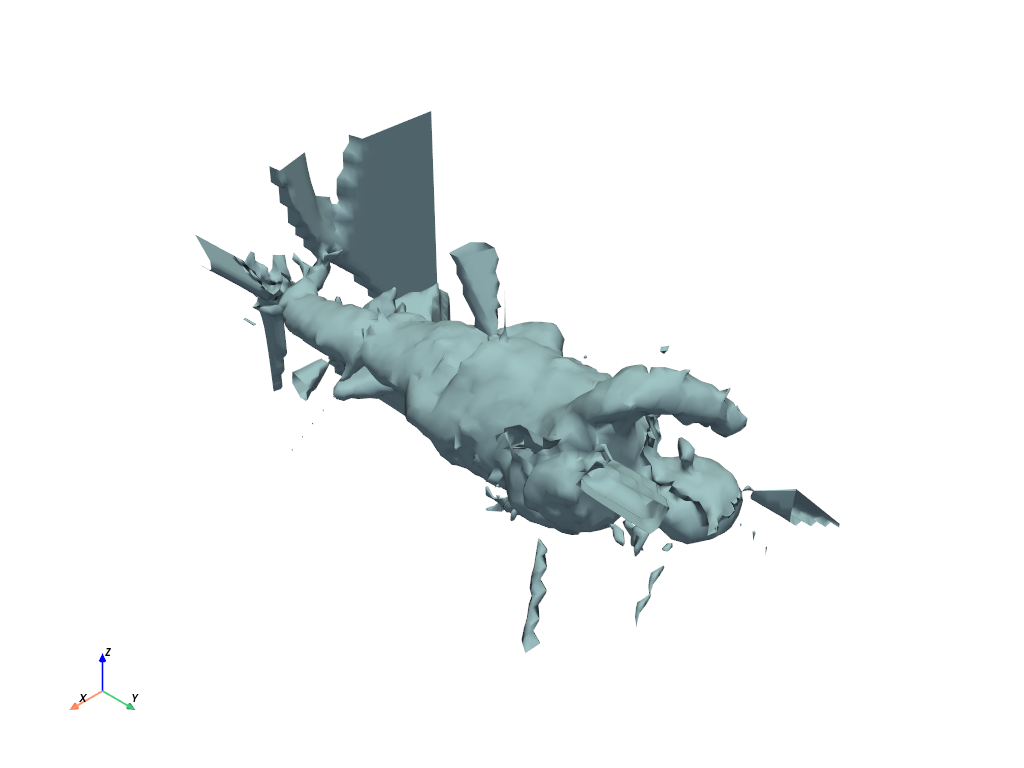

In [30]:
#
# Trying PyVista
#

import pyvista as pv

pcd = o3d.io.read_point_cloud("../assets/voxel64/19_full.ply")

# Step 2: Convert Open3D point cloud to NumPy array (vertices)
points = np.asarray(pcd.points)

# Step 3: Convert the point cloud to PyVista format (PolyData)
# PyVista needs the points as a list of coordinates.
cloud_pv = pv.PolyData(points)

surf = cloud_pv.reconstruct_surface(nbr_sz=5, sample_spacing=2)
surf = surf.clean()
surf = surf.smooth(n_iter=20)
surf.plot(show_edges=False, smooth_shading=True)